#### A character level language model :
#### name "siddhrath" would be seen as sequence of individual characters s,i,d,d,h,a,r,t,h
#### So character level language model is modeling sequences of characters and knows how 
#### to predict the next character in the sequence

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[0:10]

['barjraj',
 'ramdin verma',
 'sharat chandran',
 'birender mandal',
 'amit',
 'kushal',
 'kasid',
 'shiv prakash',
 'vikram singh',
 'sanjay']

In [4]:
len(words)

46929

#### Bigram Lang Model (BLM)
##### We only look at the previous character to predict the next one

In [5]:
# For learning the stats about which chars are likely to follow other 
# chars in BLM is to simply do it by counting
# So we are just going to count how often any of these combinations 
# appear in the train set

# This dictionary maintains counts
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for c1,c2 in zip(chs, chs[1:]):
        bigram = (c1,c2)
        b[bigram] = b.get(bigram,0) +1
        #print(c1,c2)


In [6]:
#sorted(b.items(), key = lambda kv: -kv[1])

In [7]:
#b

In [8]:
import torch

In [42]:
# create look up dict for char to index and index to char
# for indexing into matrix
# 26 english letter, <S>, <E> and " " = 29
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
# instead of using two we only use one special token
# and we place give it index 0
stoi['.']=0
itos = {i:s for s,i in stoi.items()}
#stoi, itos

In [10]:
# It is significantly more convenient to have the dict info in a 2D Array
# Rows -> First Char, Col -> 2nd Char
# Each entry tells us how often 2nd Char follows the first Char in train dataset

dim = len(chars) + 1 # 1 added for '.'
N = torch.zeros((dim,dim), dtype=torch.int32)
dim

28

In [11]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for c1,c2 in zip(chs, chs[1:]):
        ix1 = stoi[c1]
        ix2 = stoi[c2]
        N[ix1, ix2] += 1

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

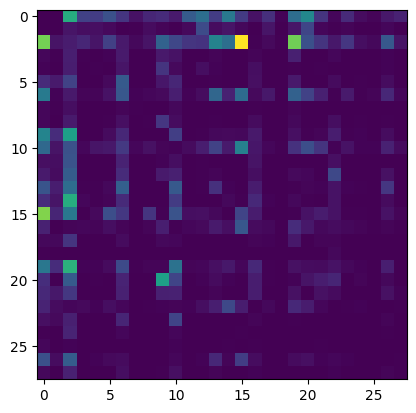

In [13]:
plt.imshow(N)

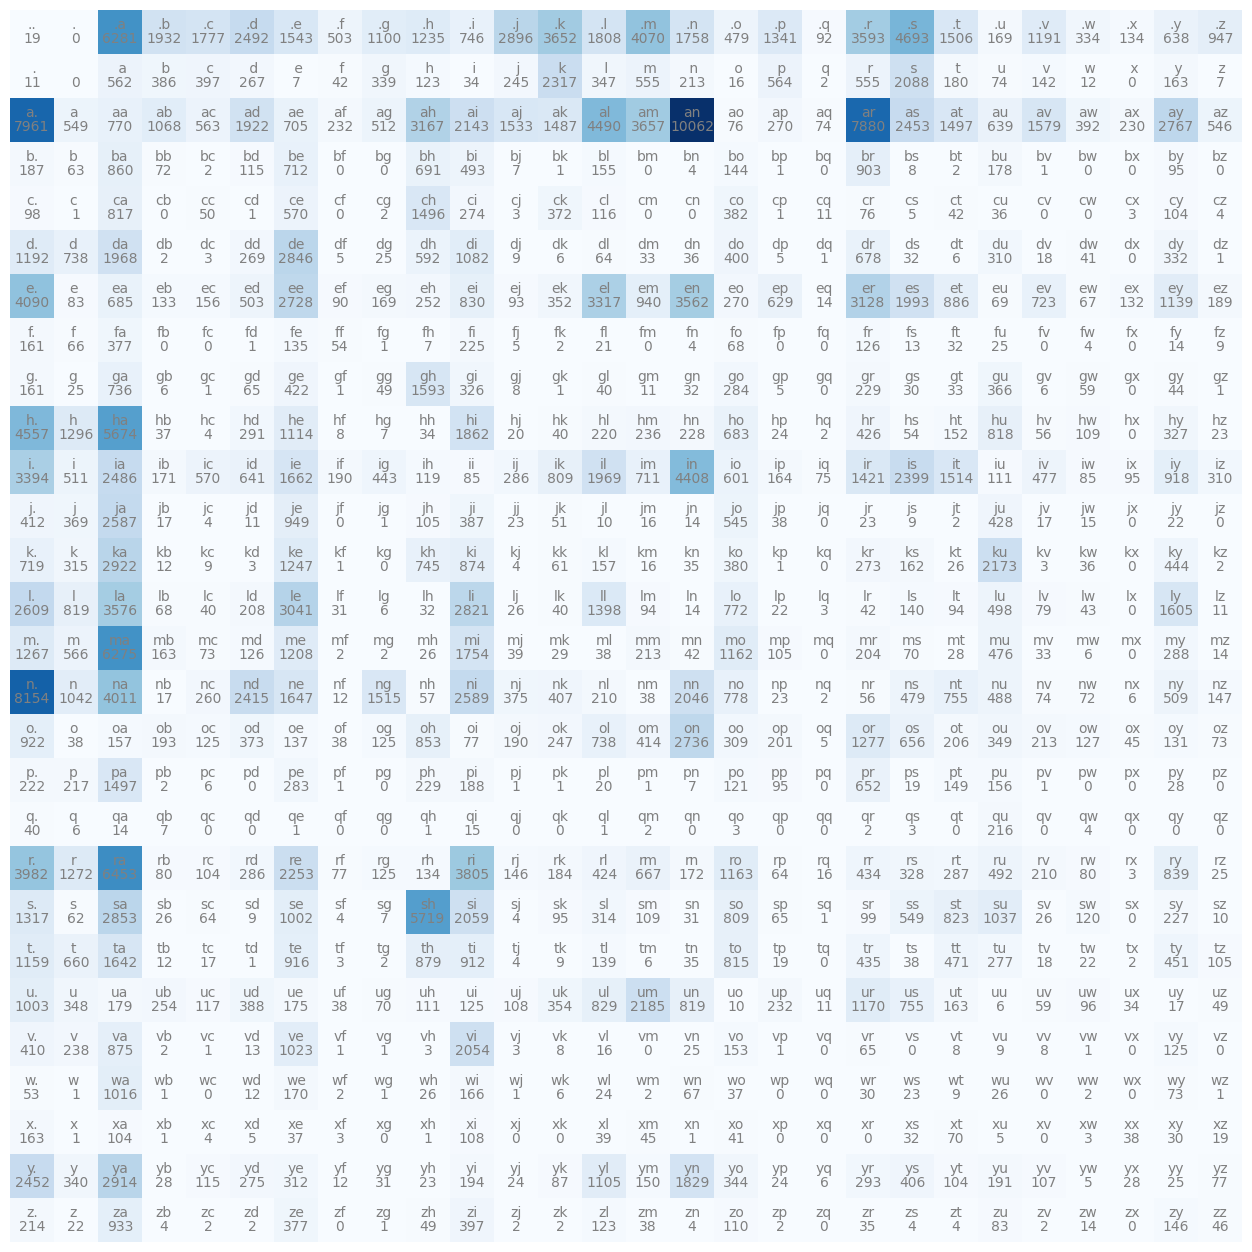

In [14]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(dim):
    for j in range(dim):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

##### We have the counts array of our dataset, it has all the info necessary needed for bigram character level
##### language model. We will just treat these frequecies as probabilities and sample next char based on them. We start with '.' , e.g first row tells us how likely is this character to start a word.

In [15]:
N[0]

tensor([  19,    0, 6281, 1932, 1777, 2492, 1543,  503, 1100, 1235,  746, 2896,
        3652, 1808, 4070, 1758,  479, 1341,   92, 3593, 4693, 1506,  169, 1191,
         334,  134,  638,  947], dtype=torch.int32)

In [16]:
# converting above counts into probabilities
p = N[0].float()
p /= p.sum()
p

tensor([0.0004, 0.0000, 0.1338, 0.0412, 0.0379, 0.0531, 0.0329, 0.0107, 0.0234,
        0.0263, 0.0159, 0.0617, 0.0778, 0.0385, 0.0867, 0.0375, 0.0102, 0.0286,
        0.0020, 0.0766, 0.1000, 0.0321, 0.0036, 0.0254, 0.0071, 0.0029, 0.0136,
        0.0202])

In [17]:
# g = torch.Generator().manual_seed(2147483647)
# p = torch.rand(3, generator=g)
# p = p / p.sum()
# p
# torch.multinomial(p, num_samples=100, replacement=True, generator=g)

In [18]:
g = torch.Generator().manual_seed(2147483647)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'k'

#### Loop for generating names from distributon

[broadcast semantics pytorch](https://docs.pytorch.org/docs/stable/notes/broadcasting.html)

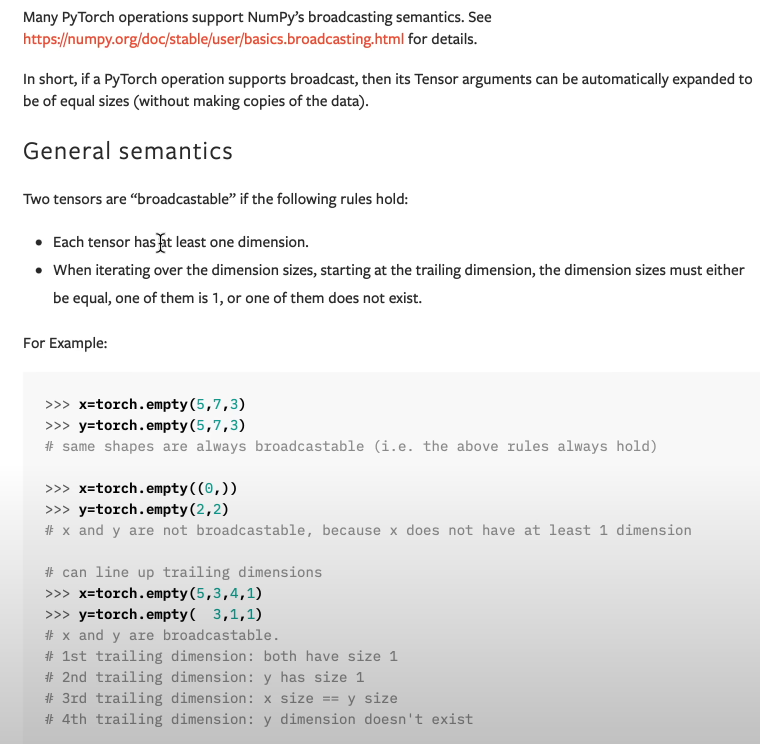

In [19]:
from IPython.display import Image, display
display(Image(filename="broadcast rules.png", width=500, height=400))

In [35]:
# +1 for model smoothing, to handle 0 probability for some valid strings
P = (N+1).float()
# Align all dimensions on right
# Iterate over all dimensions from right to left
#   -> Each dimension is equal, 1 or doesn't exist
#       28, 28
#       28, 1
#       It takes 28x1 vector and copies it 28 times creating 28x28

# P /= P.sum(1) : broadcasting works but is a bug, although it sums along rows,
# it would copy result along rows not columns

# Below line then does element wise division after broadcasting
P /= P.sum(1, keepdim=True)
#s

In [36]:
g = torch.Generator().manual_seed(2147483647)
for _ in range(10):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

k.
mich.
sor pay.
t.
ke.
shahama.
rusakshariarisay.
ar sis ty.
ananur briachomly.
ash.


#### Model evaluation and loss function

#### We think about how can we summarize these probs into a single number which measures the model's quality
##### we use likelihood which is the product of all the probs, and generally we work with log(probs) for convenience. It is telling us the probablity of entire dataset assigned by the model we have trained

##### likelihood = product of prob assigned to each data pointby the model
##### maximize likelihood ~ max log(likeihood) ~ min -log(likelihood)
##### So job of training is to find parameters that minimize -log(likelihood)

In [37]:
log_likelihood=0
n=0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for c1,c2 in zip(chs, chs[1:]):
        ix1 = stoi[c1]
        ix2 = stoi[c2]
        prob = P[ix1][ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n+=1
        #print(f'{c1}{c2} : {prob:4f} {logprob:4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-967757.6875)
nll=tensor(967757.6875)
2.494150161743164


### Neural Net Based Language Model

In [ ]:
# create train set of bigrams (x,y)
xs, ys = [], []
for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for c1,c2 in zip(chs, chs[1:]):
        ix1 = stoi[c1]
        ix2 = stoi[c2]

        xs.append(ix1)
        ys.append(ix2)

# xs = torch.Tensor(xs) // Tensor produces tensor with type fload32
# ys = torch.Tensor(ys)
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [45]:
xs, ys

(tensor([ 0,  3,  2, 19, 11, 19,  2, 11]),
 tensor([ 3,  2, 19, 11, 19,  2, 11,  0]))

In [46]:
import torch.nn.functional as F

In [51]:
xenc = F.one_hot(xs, num_classes=dim).float()
xenc.shape, xenc.dtype

(torch.Size([8, 28]), torch.float32)

In [90]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((28,28), generator=g, requires_grad=True)

In [101]:
# (8,28) @ (28,28) = (8,28) 
# 28 neurons with activation values for 8 inputs
# xenc @ W

In [92]:
# (xenc @ W)[3,13] gives activatoin vlaue for 14th neuron on 4th input
(xenc @ W)[3,13] == (xenc[3]*W[:,13]).sum()

tensor(True)

#### We are trying to produce some kind of prob distribution for next character in sequence. 
#### We interpret the output for xenc @ W as log(counts) and we exponentiate them to turn negative numbers into positive < 1 and positive numbers > 1, giving us equivalent to matrix N in some way.

##### We can put softmax on top of any neural net layer and it makes it output probabilities

In [94]:
logits = xenc @ W # log counts
# Next two lines are effectively equivalent to softmax
counts = logits.exp() # equivalent N
probs = counts / counts.sum(1, keepdim=True)
probs[0]

tensor([0.0603, 0.0099, 0.0122, 0.0042, 0.0167, 0.0122, 0.0027, 0.0230, 0.0136,
        0.0311, 0.0078, 0.0276, 0.0091, 0.0082, 0.0496, 0.2363, 0.0599, 0.0025,
        0.0248, 0.0054, 0.0337, 0.0108, 0.0029, 0.0197, 0.0117, 0.1527, 0.1450,
        0.0064], grad_fn=<SelectBackward0>)

#### Breakdown of examples as explain by Andrej

In [ ]:
# nlls = torch.zeros(5)
# for i in range(5):
#     # i-th bigram:
#     x = xs[i].item() # input character index
#     y = ys[i].item() # label character index
#     print('--------')
#     print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
#     print('input to the neural net:', x)
#     print('output probabilities from the neural net:\n',probs[i])
#     print('label (actual next character):', y)
#     p = probs[i, y]
#     print('probability assigned by the net to the correct character:', p.item())
#     logp = torch.log(p)
#     print('log likelihood:', logp.item())
#     nll = -logp
#     print('negative log likelihood:', nll.item())
#     nlls[i] = nll

# print('=========')
# print('average negative log likelihood, i.e. loss =', nlls.mean().item())

#### Using gradient descent for optimization

In [103]:
xs

tensor([ 0,  3,  2, 19, 11, 19,  2, 11])

In [104]:
ys

tensor([ 3,  2, 19, 11, 19,  2, 11,  0])

In [113]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((28,28), generator=g, requires_grad=True)

In [125]:
# forward pass
xenc = F.one_hot(xs, num_classes=dim).float()
logits = xenc @ W # log counts
# Next two lines are effectively equivalent to softmax
counts = logits.exp() # equivalent N
probs = counts / counts.sum(1, keepdim=True)
loss = -probs[torch.arange(8),ys].log().mean()
loss.item()

3.3079919815063477

In [123]:
W.grad = None # set to zero
loss.backward(  )

In [124]:
W.data += -0.1*W.grad

#### Putting it all together

In [142]:
# creating dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((dim, dim), generator=g, requires_grad=True)

number of examples:  388011


#### Because xenc is made up of hot vectors, xenc*W effective picks the distribution for next char from W (as its row after normalization), like it happened earlier with N matrix. We can interpret it in this way because W has 28 columns (same as size of char set), this interpretation will not hold for any other number

#### W has log(counts), so W.exp(), in some sense, is same as N which contains bigrams count. We learnt W by initializing it randomly and then using gradient descent optimization of a loss i.e (-log likelihood)

## regularized loss function : 
##### loss = -probs[torch.arange(num),ys].log().mean() + 0.01*(W**2).mean()
### This incentivizes W entries to be around 0, which gives smooth prob distr. This is similar to adding constant to N matrix of bigram counts, adding bigger counts is same as giving more importance to (W**2).mean() in this loss function

In [ ]:
for k in range(100):
    xenc = F.one_hot(xs, num_classes=dim).float()
    logits = xenc @ W # log counts
    # Next two lines are effectively equivalent to softmax
    counts = logits.exp() # equivalent N
    probs = counts / counts.sum(1, keepdim=True)
    
    loss = -probs[torch.arange(num),ys].log().mean()
    #loss = -probs[torch.arange(num),ys].log().mean() + 0.01*(W**2).mean()

    print(loss.item())

    # backward pass
    W.grad = None
    loss.backward()

    # update
    W.data += -50*W.grad

2.497131586074829
2.4971201419830322
2.4971086978912354
2.4970974922180176
2.4970860481262207
2.497074842453003
2.497063398361206
2.4970521926879883
2.4970414638519287
2.497030258178711
2.4970195293426514
2.4970085620880127
2.496997833251953
2.4969868659973145
2.496976137161255
2.4969654083251953
2.4969546794891357
2.4969444274902344
2.496933698654175
2.4969232082366943
2.496912717819214
2.4969024658203125
2.496892213821411
2.4968819618225098
2.4968717098236084
2.496861457824707
2.4968512058258057
2.4968414306640625
2.496831178665161
2.496821403503418
2.4968113899230957
2.4968013763427734
2.4967918395996094
2.496782064437866
2.496772289276123
2.496762752532959
2.496752977371216
2.496743679046631
2.4967339038848877
2.4967243671417236
2.4967150688171387
2.4967055320739746
2.4966962337493896
2.4966869354248047
2.4966776371002197
2.4966683387756348
2.496659517288208
2.496649980545044
2.496641159057617
2.4966320991516113
2.4966232776641846
2.4966142177581787
2.496605396270752
2.496596336364

### Generating using Neural Net Model

In [205]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(10):
    out = []
    ix = 0
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=dim).float()
        logits = xenc @ W # predict log-counts
        counts = logits.exp() # counts, equivalent to N
        p = counts / counts.sum(1, keepdims=True) # probabilities for next character

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break

    print(''.join(out))

k.
mich.
sor pay.
t.
ke.
shahama.
rusakshariarisay.
ar sis ty.
ananur briachomqviash.
rinohane.
